<center><h1><b><span style="color:blue">Fitting</span></b></h1></center>

#### **Quick intro to the following packages**
- The core package `iminuit`.
- Model building and a word on the affiliated package `zfit`.

<center>
&nbsp;<br><h1><b>iminuit</b></h1>

<h2><b><span style="color:green">Python wrapper to Minuit2 minimization and error computation package</span></b></h2></center>

The `iminuit` package provides Python bindings for the [C++ Minuit2 library](https://root.cern.ch/guides/minuit2-manual) maintained at CERN, which is effectively the only fitting engine used in HEP. The package has no external dependency apart from NumPy.

Note: feel free to complement the introduction below with the several tutorials available from the [GitHub repository](https://github.com/scikit-hep/iminuit).

## **1. A very simple example**

Minimisation of a function:

In [1]:
from iminuit import Minuit

def f(x, y, z):
    return (x - 2) ** 2 + (y - 3) ** 2 + (z - 4) ** 2

m = Minuit(f)

m.migrad()  # run optimiser

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:6: InitialParamWarning: Parameter x does not have initial value. Assume 0.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:6: InitialParamWarning: Parameter x is floating but does not have initial step size. Assume 1.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:6: InitialParamWarning: Parameter y does not have initial value. Assume 0.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:6: InitialParamWarning: Parameter y is floating but does not have initial step size. Assume 1.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:6: InitialParamWarning: Parameter z does not have initial value. Assume 0.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:6: InitialParamWarning: Parameter z is floating but does not have initial step size. Assume 1.
  
/srv/conda/envs/notebo

------------------------------------------------------------------
| FCN = 1.624E-22               |      Ncalls=36 (36 total)      |
| EDM = 1.62E-22 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x    |    2.0    |    1.0    |            |            |         |         |       |
| 1 | y    |    3.0    |    1.0    |            |            |         |         |       |
| 2 | z    |    4.0    |    1.0    |            |            |         |         |       |
------------------------------------------------------------------------------------------

## **2. A more evolved example**

Let's look at a little sample of track information generated with a toy.

<div class="alert alert-info">

<b>Acknowledgements</b>

This mini-tutorial is kindly provided by Hans Dembinski (TU Dortmund), with minor modifications.
</div>

In [2]:
import uproot

f = uproot.open("data/toy-sample-tracks.root")

event = f["event"]

In [3]:
event.show()

trk_len                    (no streamer)              asdtype('>i4')
mc_trk_len                 (no streamer)              asdtype('>i4')
trk_imc                    (no streamer)              asjagged(asdtype('>i4'))
trk_px                     (no streamer)              asjagged(asdtype('>f4'))
trk_py                     (no streamer)              asjagged(asdtype('>f4'))
trk_pz                     (no streamer)              asjagged(asdtype('>f4'))
mc_trk_px                  (no streamer)              asjagged(asdtype('>f4'))
mc_trk_py                  (no streamer)              asjagged(asdtype('>f4'))
mc_trk_pz                  (no streamer)              asjagged(asdtype('>f4'))
mc_trk_pid                 (no streamer)              asjagged(asdtype('>i4'))


Legend :-):
* mc_trk_len: number of true tracks in event
* mc_trk_px: x-component of true momentum of particle (variable-length array)
* mc_trk_py: y-component of true momentum of particle (variable-length array)
* mc_trk_pz: z-component of true momentum of particle (variable-length array)
* trk_len: number of reconstructed tracks in event
* trk_px: x-component of momentum of reconstructed track (variable-length array)
* trk_py: y-component of momentum of reconstructed track (variable-length array)
* trk_pz: z-component of momentum of reconstructed track (variable-length array)
* trk_imc: index of matched true particle or -1 (variable-length array)

Get the content of branches as arrays (don't use this in large trees - you will exhaust the computer memory):

In [4]:
trk_len, mc_trk_len = event.arrays(["trk_len", "mc_trk_len"]).values()
trk_px, trk_py, trk_pz = event.arrays(["trk_p[xyz]*"]).values()

In [5]:
# first ten entries, this is a normal numpy array
trk_len[:10]

array([2, 4, 4, 9, 2, 6, 5, 4, 6, 6], dtype=int32)

In [6]:
import numpy as np

print(f"{np.sum(trk_len == 0)} events with zero tracks")

13 events with zero tracks


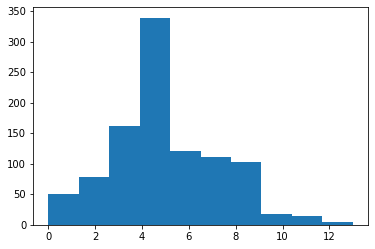

In [7]:
import matplotlib.pyplot as plt

plt.hist(trk_len);

In [8]:
# first ten entries, trk_px is a special jagged array
trk_px[:10]

<JaggedArray [[0.16874836 0.9070307] [-1.265933 0.42538995 -0.041526724 0.0646198] [-0.09828822 -0.2942412 0.510422 -0.17276697] ... [0.43742535 -0.30726758 0.18478443 -0.4186635] [-0.118606664 -0.91890717 -0.5203567 -0.25899968 -0.13334757 1.0575198] [0.63578767 0.9840505 0.42291006 0.17706154 -0.10899911 0.19687186]] at 0x7f854fcd45d0>

In [9]:
trk_px.content[:20], trk_px.starts[:10], trk_px.stops[:10]

(array([ 0.16874836,  0.9070307 , -1.265933  ,  0.42538995, -0.04152672,
         0.0646198 , -0.09828822, -0.2942412 ,  0.510422  , -0.17276697,
         0.5130861 ,  0.02814896,  0.136026  , -0.33734408,  1.0820657 ,
        -0.17475943,  0.06826229, -0.09163328,  0.8744177 ,  0.61232555],
       dtype=float32),
 array([ 0,  2,  6, 10, 19, 21, 27, 32, 36, 42]),
 array([ 2,  6, 10, 19, 21, 27, 32, 36, 42, 48]))

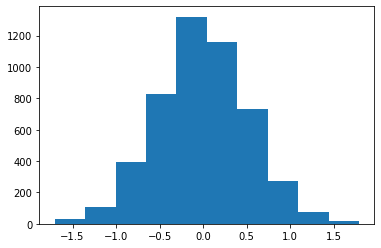

In [10]:
plt.hist(trk_px.content);

#### **Fits**

* Typical analysis work flow:
    1. Pre-select data and make compact data trees
    2. Make histograms and profiles from tree data
    3. Fit histograms and profiles to extract physical parameters
* Many specialized fitting tools for individual purposes, e.g.:
    - [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit)
    - [RooFit](https://root.cern.ch/roofit)
* Generic method
    - Select mathematical model (PDF) which describes data
    - Use maximum-likelihood method to adapt model to data
* Specialised methods give fast results for some types of problems
* Generic method allows one to do advanced things not implemented in specialised methods

Let's fit the px distribution with a normal distribution to extract the parameters $\mu$ and $\sigma$.

- To apply a maximum-likelihood method, we need a statistical model that describes the data
- Assumption 1: original data before histogramming is normal distributed; pdf is $\mathcal{N}(\mu, \sigma)$ with parameters $\mu$ and $\sigma$
- Assumption 2: count in histogram cell is Poisson distributed $P(n_i, \lambda_i)$
- Expected content in a histogram cell is $\lambda_i = N \int_{x_i}^{x_{i+1}} \mathcal{N}(\mu, \sigma) \, \text{d}x$, where $N$ is total number of events
- Likelihood is joint probability of data under model
  $L = \prod_i P(n_i, \lambda_i)$, need to maximize this by varying model parameters $\mu$ and $\sigma$
- Technical step to achieve this: Minimize score $S(\mu,\sigma) = -2\ln L(\mu, \sigma) = -2\sum_i \ln P(n_i; \lambda_i)$

In [11]:
import boost_histogram as bh

xaxis = bh.axis.Regular(50, -2, 2)
h_px = bh.Histogram(xaxis)

h_px.fill(trk_px.content)

Histogram(Regular(50, -2, 2), storage=Double()) # Sum: 4934.0

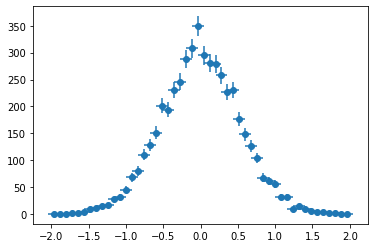

In [12]:
# scipy has efficient and correct implementations for most statistical distributions
from scipy.stats import norm, poisson

# get data from before
px_axis = h_px.axes[0]
cx = px_axis.centers
dx = px_axis.widths
xe = px_axis.edges
n = h_px.view()

plt.errorbar(cx, n, n**0.5, dx, fmt="o", label="data");

In [13]:
n_total = np.sum(n)

def score(mu, sigma):
    cdf = norm(mu, sigma).cdf
    lambdas = n_total * (cdf(xe[1:]) - cdf(xe[:-1]))
    probs = poisson.pmf(n, lambdas)
    return -2 * np.sum(np.log(probs + 1e-100)) # avoid taking log of zero

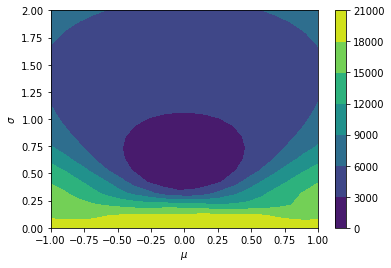

In [14]:
from matplotlib.ticker import LogLocator

mus = np.linspace(-1, 1, 20)
sigmas = np.linspace(1e-10, 2, 20)

g_mu, g_sigma = np.meshgrid(mus, sigmas)
g_score = np.vectorize(score)(g_mu, g_sigma)

plt.contourf(g_mu, g_sigma, g_score)
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.colorbar();

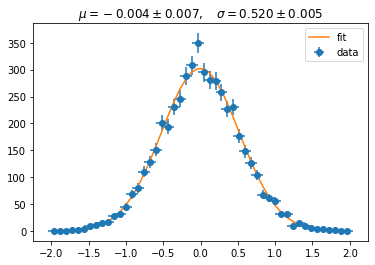

In [15]:
m = Minuit(score, mu=0, sigma=1, limit_sigma=(0, None), pedantic=False)
m.migrad()

mu, sigma = m.values.values()
s_mu, s_sigma = m.errors.values()

plt.errorbar(cx, n, n ** 0.5, dx, fmt="o", label="data");
plt.plot(cx, norm(mu, sigma).pdf(cx) * n_total * dx, label="fit")
plt.title(f"$\mu = {mu:.3f} \pm {s_mu:.3f}, \quad \sigma = {sigma:.3f} \pm {s_sigma:.3f}$")
plt.legend();

Check whether the fit is good:
- by looking at *pull distribution*
    - $(n_i - \lambda_i) / \lambda_i$ for Poisson distribute data
- by checking the $\chi^2$ value against the degrees of freedom
    - Simple check: $\chi^2/n_\text{dof}$ should be about 1
    - Better check: chance probability $\int_{\chi^2_\text{observed}}^{-\infty} P(\chi^2; n_\text{dof}) \, \text{d}\chi^2$ to obtain a higher value than the observed should not be too small

chi2/ndof = 40.288361871483076 / 48 = 0.839340872322564
0.7777466970541109


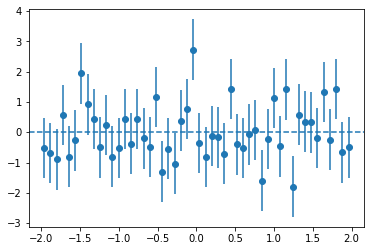

In [16]:
cdf = norm(mu, sigma).cdf

n_pred = (cdf(xe[1:]) - cdf(xe[:-1])) * n_total
n_sigma = n_pred ** 0.5 # for Poisson-distributed data

pull = (n - n_pred) / n_sigma

plt.errorbar(cx, pull, np.ones_like(pull), fmt="o")
plt.axhline(0, ls="--")

# degrees of freedom: number of fitted bins minus number of fitted parameters
n_dof = len(n) - 2 # need to subtract two fitted parameters

chi2_obs = np.sum(pull ** 2)

print(f"chi2/ndof = {chi2_obs} / {n_dof} = {chi2_obs / n_dof}")

from scipy.stats import chi2

chance_prob = 1 - chi2(n_dof).cdf(chi2_obs)

print(f"{chance_prob}")

## **3. Towards realistic HEP data usecases**

HEP analyses typically involve far more sophisticated fitting work. It is often about *data model building* and performing *unbinned maximum likelihood fits* to describe experimental distributions.

The ROOT framework provides [RooFit](https://root.cern.ch/roofit) as a model fitting library. We will end this tutorial playing with the `zfit` package, a new-ish Pmodel fitting library based on TensorFlow and optimised for simple and direct manipulation of probability density functions.